In [15]:
import coba as cb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

figsize = (8,6)
plt.rc('font',weight='normal',size=16)
plt.rcParams['lines.markersize'] = 15
plt.rcParams['lines.linewidth'] = 3
cb.CobaContext.store['elinewidth'] = 1

In [2]:
online_env = cb.Environments.from_save('../outcomes/online1.zip')+\
             cb.Environments.from_save('../outcomes/online2.zip')+\
             cb.Environments.from_save('../outcomes/online3.zip')

In [3]:
%%time
online = cb.Result.from_logged_envs(online_env.batch(8))
offline = cb.Result.from_file('../outcomes/offline.gz')

CPU times: total: 8min 13s
Wall time: 8min 23s


In [3]:
online.learners.to_pandas()

,learner_id,APD,argmax,eta,family,gscale,gzero,k_inf,lr,n_taus,sampler,tau_max,tau_min,tz,v,weight
0,0,4,linear,0.3,LargeActionLearner,gz_plus_18_times_t,1,4.0,0.02,12,new,1024,6,100,1,False
1,1,4,linear,0.3,LargeActionLearner,gz_plus_100_times_t_to_3_4,1,NaN,0.02,12,old,2048,2,100,1,False
2,2,4,linear,0.3,LargeActionLearner,gz_plus_18_times_t,1,24.0,0.02,12,new,1024,6,100,1,False
3,3,4,linear,0.3,LargeActionLearner,gz_plus_18_times_t,1,2.0,0.02,12,new,1024,6,100,1,False


In [5]:
from collections import Counter

# The number of learners for each environment
X = Counter([e for e,l in set(online.interactions[['environment_id','learner_id']])])

# Every environment_id that was completed for all 4 learners
A = [k for k,v in X.items() if v == 4]

#An even number of environments for every openml data set
E = online.environments.to_pandas().iloc[[k for k,v in X.items() if v == 4]].fillna(0).groupby(['openml_task','openml_data']).head(2)['environment_id'].tolist()

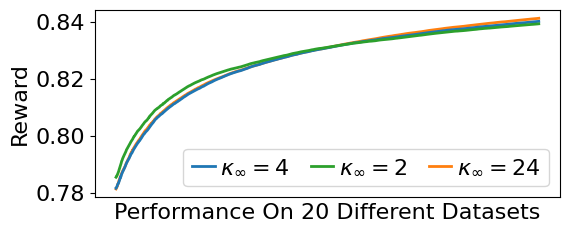

In [69]:
#This is the most fair comparison of overall performance
#The reason this is different from contrast is because
#it terminates at ~1000.
plt.rcParams['lines.linewidth'] = 2

plt.figure(figsize=(6,3.75))

online.filter_fin(4000).filter_env(environment_id=E).filter_lrn(learner_id=[0,2,3]).plot_learners(xlim=(200,None),labels=[r'$\kappa_\infty=4$',r'$\kappa_\infty=24$',r'$\kappa_\infty=2$'],out=None)

plt.title('',loc='left')
plt.xticks([])
plt.xlabel('Performance On 20 Different Datasets')
plt.ylabel('Reward')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncols=3, handlelength=1, handletextpad=.25, columnspacing=1)

plt.show()

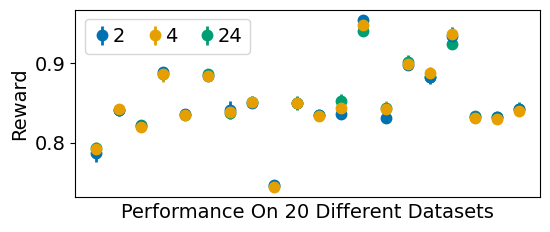

In [110]:
plt.figure(figsize=(6,3.75))

online.filter_fin().filter_env(environment_id=E).filter_lrn(learner_id=[0,2,3]).plot_learners(x=['openml_task','openml_data'],labels=['4','24','2'],colors=[c2,c3,c1],err='se',out=None)

plt.title('',loc='left')
plt.xticks([])
plt.xlabel('Performance On 20 Different Datasets')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncols=3, handlelength=1, handletextpad=.05, columnspacing=1)

#plt.show()
plt.savefig('k_online.pdf',format='pdf', bbox_inches="tight")

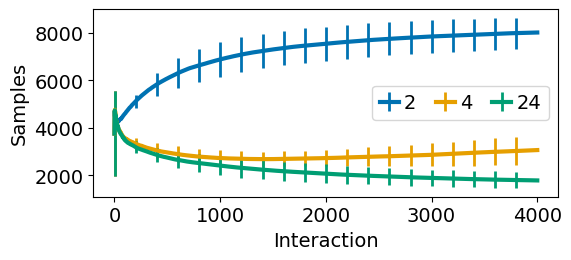

In [113]:
plt.figure(figsize=(6,3.75))

online.filter_fin(4000).filter_lrn(learner_id=[0,2,3]).filter_env(environment_id=E).plot_learners(y='samples',labels=['4','24','2'],colors=[c2,c3,c1],err='sd',out=None)

plt.title('',loc='left')
#plt.xticks([])
#plt.xlabel('Performance On 20 Different Datasets')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncols=3, handlelength=1, handletextpad=.25, columnspacing=1, loc='center right')

#plt.show()
plt.savefig('k_samps.pdf',format='pdf', bbox_inches="tight")

Environments not present for all learners have been excluded. To supress this call filter_fin() before plotting.


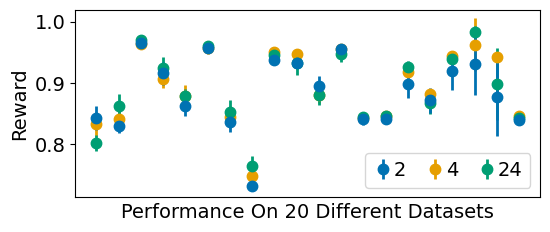

In [114]:
plt.figure(figsize=(6,3.75))

offline.filter_lrn(learner_id=[1,2,3]).plot_learners(x=['openml_task','openml_data'],labels=['4','2','24'],colors=[c2,c1,c3],err='se', out = None)
plt.title('',loc='left')
plt.xticks([])
plt.xlabel('Performance On 20 Different Datasets')

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncols=3, handlelength=1, handletextpad=.05, columnspacing=1)

#plt.show()
plt.savefig('k_offline.pdf',format='pdf', bbox_inches="tight")

In [75]:
from collections import defaultdict

L = defaultdict(list)

for e in online_env:
    if e.params['learner']['sampler']=='new':
        k = e.params['learner']['k_inf']
        for i in e.read():
            L[k].append(i['probability'])


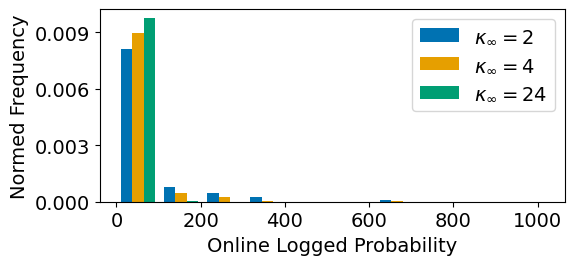

In [309]:
H = []
C = []

counts, bins = np.histogram([l for l in L[2] if l is not None],bins=10)
H.append(bins[:-1])
C.append(counts)

counts, bins = np.histogram([l for l in L[4] if l is not None],bins)
H.append(bins[:-1])
C.append(counts)

counts, bins = np.histogram([l for l in L[24] if l is not None],bins)
H.append(bins[:-1])
C.append(counts)

plt.figure(figsize=(6,2.5))

plt.hist(np.array(H).T, bins, weights=np.array(C).T, density=True, color=[c1,c2,c3], label=['$\kappa_\infty=2$','$\kappa_\infty=4$','$\kappa_\infty=24$'])

plt.ylabel('Normed Frequency')
plt.xlabel('Online Logged Probability')

plt.yticks([0,.003,.006,.009])

plt.legend()

#plt.show()
plt.savefig('k_prob.pdf',format='pdf', bbox_inches="tight")

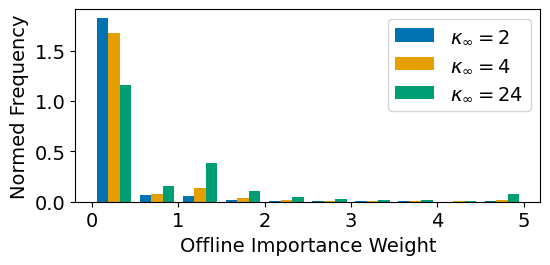

In [310]:
H = []
C = []

counts, bins = np.histogram([min(1/l,5) for l in L[2 ] if l is not None],bins=10)
H.append(bins[:-1])
C.append(counts)

counts, bins = np.histogram([min(1/l,5) for l in L[4 ] if l is not None],bins)
H.append(bins[:-1])
C.append(counts)

counts, bins = np.histogram([min(1/l,5) for l in L[24] if l is not None],bins)
H.append(bins[:-1])
C.append(counts)

plt.figure(figsize=(6,2.5))

plt.hist(np.array(H).T, bins, weights=np.array(C).T, density=True, color=[c1,c2,c3], label=['$\kappa_\infty=2$','$\kappa_\infty=4$','$\kappa_\infty=24$'])
plt.legend()

plt.ylabel('Normed Frequency')
plt.xlabel('Offline Importance Weight')

#plt.show()
plt.savefig('k_ips.pdf',format='pdf', bbox_inches="tight")

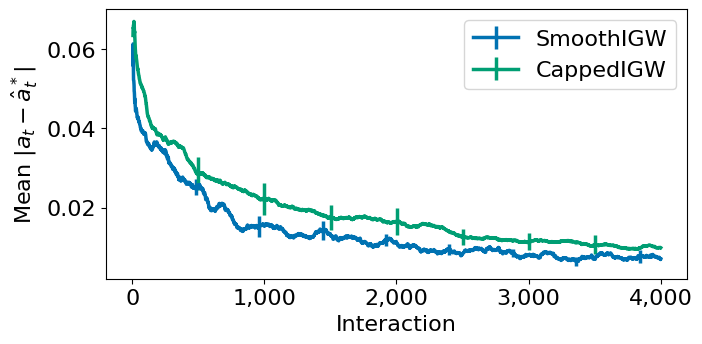

In [36]:
df = online.filter_env(environment_id=E).filter_fin(4000).interactions.to_pandas()
df['gdiff'] = (df['action']-df['greedy']).abs()

roll = df.drop(['action','greedy','reward','samples'],axis=1).set_index(['environment_id','learner_id','index']).unstack(level=[1,0]).rolling(100,min_periods=6).mean()
yerr = roll.groupby('learner_id',axis=1).sem()
data = roll.groupby('learner_id',axis=1).mean()

plt.figure(figsize=(7.5,3.5))
cb.CobaContext.store['elinewidth'] = 5
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 50


plt.errorbar(x=list(range(1,4001)),y=data.iloc[:,1],yerr=yerr.iloc[:,1]*1.96,errorevery=480, color=c1, label='SmoothIGW')
plt.errorbar(x=list(range(1,4001)),y=data.iloc[:,2],yerr=yerr.iloc[:,2]*1.96,errorevery=500, color=c3, label=r'CappedIGW')

plt.legend()

plt.ylabel("Mean $|a_t-\hat a^*_t|$")
plt.xlabel("Interaction")
plt.xticks([0,1000,2000,3000,4000],[0,'1,000','2,000','3,000','4,000'])

#plt.show()
plt.savefig('k_spread.pdf',format='pdf', bbox_inches="tight")


In [250]:
online.learners.to_pandas()

,learner_id,APD,argmax,eta,family,gscale,gzero,k_inf,lr,n_taus,sampler,tau_max,tau_min,tz,v,weight
0,0,4,linear,0.3,LargeActionLearner,gz_plus_18_times_t,1,4.0,0.02,12,new,1024,6,100,1,False
1,1,4,linear,0.3,LargeActionLearner,gz_plus_100_times_t_to_3_4,1,NaN,0.02,12,old,2048,2,100,1,False
2,2,4,linear,0.3,LargeActionLearner,gz_plus_18_times_t,1,24.0,0.02,12,new,1024,6,100,1,False
3,3,4,linear,0.3,LargeActionLearner,gz_plus_18_times_t,1,2.0,0.02,12,new,1024,6,100,1,False
